# Non-zero densities and temperatures

A Lagrangian for a nucleon field $\psi$ with a point-like chirally symmetric four-fermion interaction.

$$
\mathcal{L} = \bar{\psi}(i\gamma\partial - m)\psi + G\left\{(\bar{\psi}\psi)^2 + (\bar{\psi}i\gamma^5\vec{\tau}\psi)^2\right\}
$$

In [1]:
using Plots
using LaTeXStrings
using QuadGK  # 数値積分のためのパッケージ
using NLsolve

### Parameters

In [2]:
include("src/constants.jl")

Nf, Nc, Lambda, Gs, Gv, m are global variables.
Nf_o, Nc_o, Lambda_o, G, m_o are global variables.


### Functions for the total quark number density.

In [3]:
function np(p, T, mu, M)
    """
    Fermi occupation numbers of quarks
    """
    Ep = sqrt(p^2 + M^2)
    return 1.0/(exp((Ep-mu)/T) + 1.0)
end

function np_bar(p, T, mu, M)
    """
    Fermi occupation numbers of antiquarks
    """
    Ep = sqrt(p^2 + M^2)
    return 1.0/(exp((Ep+mu)/T) + 1.0)
end

function num_dens(T, mu, M)
    """
    Computes the total quark number density with 3D momentum integration.
    """
    function integrand_numdens(p)
        if T > 0.0
            return (np(p, T, mu, M) - np_bar(p, T, mu, M))*p^2  # polar coordinates!
        else
            Ep = sqrt(p^2 + M^2)
            step_function = x -> x >= 0 ? 1.0 : 0.0
            return step_function(mu-Ep)*p^2
        end
    end
    # try
    integral, _ = quadgk(integrand_numdens, 0.0, Lambda)
    return 4.0 * Nf * Nc / (2.0 * π)^2 * integral  # 4π is multiplied ! 
    # catch e
    #     println("Error at num_dens: ", e)
    #     return NaN
    # end
end

num_dens (generic function with 1 method)

In [4]:
eps(Float64)

2.220446049250313e-16

### Solve the gap equation.

In [5]:
function gap_eq(M; T=0.0, mu=0.0)
    function integrand_gapeq(p)
        if T > 0.0
            Ep = sqrt(p^2 + M^2)
            return M/Ep*(1.0 - np(p, T, mu, M) - np_bar(p, T, mu, M))*p^2  # polar coordinates!
        else
            Ep = sqrt(p^2 + M^2)
            step_function = x -> x >= 0 ? 1.0 : 0.0
            return M/Ep*(1.0 - step_function(mu-Ep))*p^2
        end
    end
    # try
    integral, _ = quadgk(integrand_gapeq, 0.0, Lambda)
    return 8.0*Nf*Nc*G/(2.0*π)^2*integral + m - M # 4π is multiplied ! 
    # catch e
    #     println("Error at gap_eq: ", e)
    # end
end

# Solve for M using a root-finding method
function find_M(Temp, μ)
    M_guess = 1e3
    M_temp = M_guess
    m_step = 1e2
    while abs(gap_eq(M_temp; T=Temp, mu=μ)) > 1e-4 && M_guess > 0.0
        M_guess -= m_step
        sol = nlsolve(x -> [gap_eq(x[1]; T=Temp, mu=μ)], [M_guess])
        M_temp = sol.zero[1]
    end
    # println(M_guess, ", ", M_temp)
    return M_temp  # Extract the solution for M
end

find_M (generic function with 1 method)

### Results

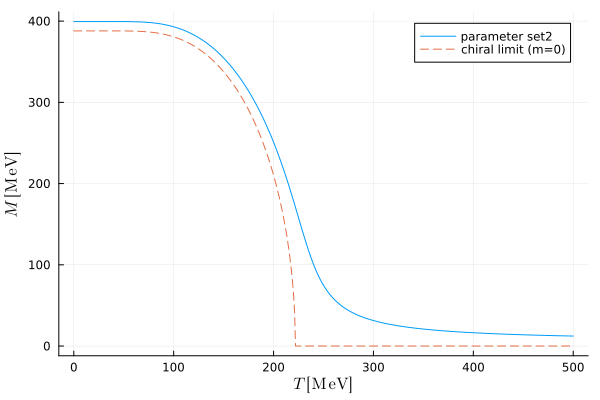

In [6]:
T = 0.0:500.0
m = 5.6  # MeV
plot(T,  find_M.(T, 0.0);
    ylabel=L"M\ [\mathrm{MeV}]",
    xlabel=L"T\ [\mathrm{MeV}]",
    label="parameter set2"
)
m = 0.0
plot!(T,  find_M.(T, 0.0);
    linestyle=:dash,
    label="chiral limit (m=0)"
)

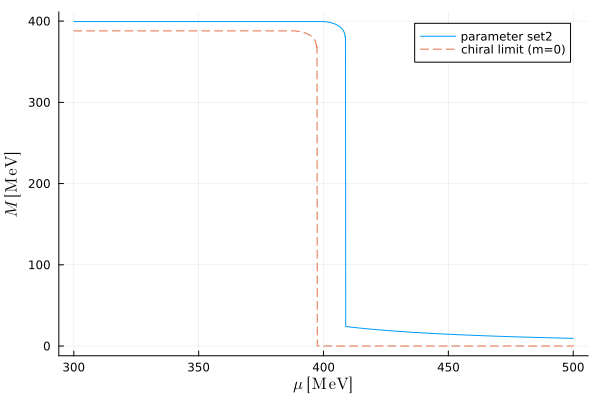

In [7]:
mu =3e2:1e-1:5e2
temperature= 0.0

m = 5.6  # MeV

mu_list = []
M_list = []
for mu_val in mu
    M_temp = find_M(temperature, mu_val)
    # if abs(gap_eq(M_temp; T=temperature, mu=mu_val)) > 1e-8
    #     println(mu_val, ", ", gap_eq(M_temp; T=temperature, mu=mu_val))
    # end
    push!(mu_list, mu_val)
    push!(M_list, M_temp)
end
plot(mu_list, M_list;
    label="parameter set2",
    xlabel=L"\mu\ [\mathrm{MeV}]",
    ylabel=L"M\ [\mathrm{MeV}]",
)

m = 0.0  # MeV
mu_list0 = []
M_list0 = []
for mu_val in mu
    M_temp = find_M(temperature, mu_val)
    push!(mu_list0, mu_val)
    push!(M_list0, M_temp)
end
plot!(mu_list0, M_list0;
    label="chiral limit (m=0)",
    linestyle=:dash,
)

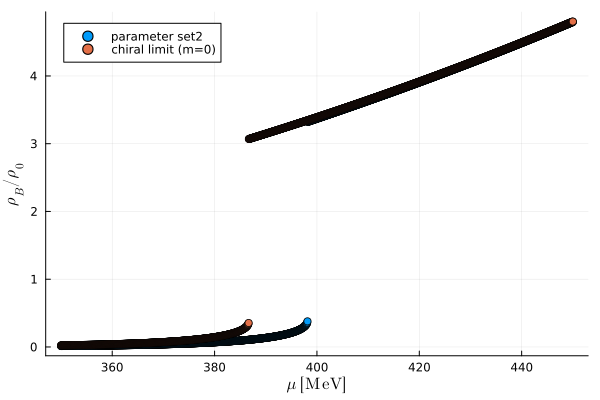

In [8]:
mu =3.5e2:5e-2:4.5e2
m = 5.6  # MeV
temperature=  2e1

M_list = []
rho_list = []
for mu_val in mu
    M_temp = find_M(temperature, mu_val)
    num_temp = num_dens(temperature, mu_val, M_temp)
    push!(M_list, M_temp)
    push!(rho_list, num_temp/hbarc^3/rho0/3.0)  # devided by 3.0 to convert quark density to baryon de
end
scatter(mu, rho_list;
    label="parameter set2",
    xlabel=L"\mu\ [\mathrm{MeV}]",
    ylabel=L"\rho_B/\rho_0",
)

m = 0.0  # MeV
M_list0 = []
rho_list0 = []
for mu_val in mu
    M_temp = find_M(temperature, mu_val)
    num_temp = num_dens(temperature, mu_val, M_temp)
    push!(M_list0, M_temp)
    push!(rho_list0, num_temp/hbarc^3/rho0/3.0)
end
scatter!(mu, rho_list0;
    linestyle=:dash,
    label="chiral limit (m=0)",
)

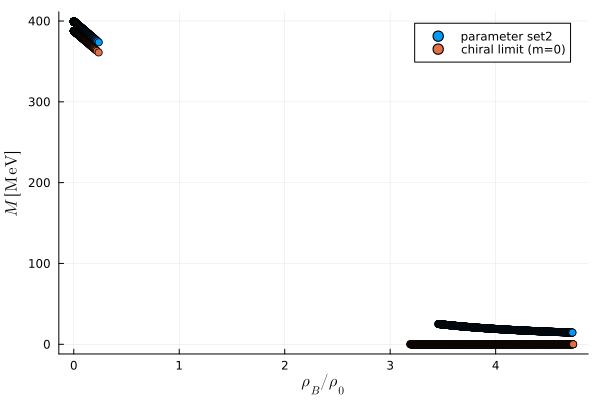

In [9]:
mu =3.5e2:5e-2:4.5e2
m = 5.6  # MeV
temperature=  1e1

M_list = []
rho_list = []
for mu_val in mu
    M_temp = find_M(temperature, mu_val)
    num_temp = num_dens(temperature, mu_val, M_temp)
    push!(M_list, M_temp)
    push!(rho_list, num_temp/hbarc^3/rho0/3.0)  # devided by 3.0 to convert quark density to baryon de
end
scatter(rho_list, M_list;
    label="parameter set2",
    xlabel=L"\rho_B/\rho_0",
    ylabel=L"M\ [\mathrm{MeV}]",
)

m = 0.0  # MeV
M_list0 = []
rho_list0 = []
for mu_val in mu
    M_temp = find_M(temperature, mu_val)
    num_temp = num_dens(temperature, mu_val, M_temp)
    push!(M_list0, M_temp)
    push!(rho_list0, num_temp/hbarc^3/rho0/3.0)
end
scatter!(rho_list0, M_list0;
    linestyle=:dash,
    label="chiral limit (m=0)",
)

## Thermodynamics potential

After a reinterpretation of NJL model as a quark model, many authors kept the original form of Lagrangian, with $\psi$ now being a quark field with Nf flavor and Nc color degree of freedom.

To keep the discussion rather general, the following Lagrangian is used.
$$
\mathcal{L}=\bar{q}(i\gamma\partial-m)q+G_S\left\{(\bar{q}q)^2 + (\bar{q}i\gamma^5\vec{\tau}q)^2\right\}-G_V(\bar{q}\gamma^{\mu}q)^2+ \ ...
$$
Consider two non-vanishing "condensates"
$$
\phi = <\bar{q}q>,\ \ n = <\bar{q}\gamma^0q>.
$$
After liniarization, introduce
$$
M = m - 2G_S\phi, \ \ \tilde{\mu} = \mu -2G_V n.
$$
In the end,
$$
\mathcal{L}+\mu q^{\dagger}q=\bar{q}(i\gamma\partial-M)q+\tilde{\mu}q^\dagger q-\frac{(M-m)^2}{4G_S}-\frac{(\mu-\tilde{\mu})^2}{4G_V}
$$

In [10]:
function OmegaM(Temp, μ_t, Mass)
    # println(Temp, ", ", μ_t, ", ", Mass)
    function integrand_OmegaM(p)
        Ep = sqrt(p^2+Mass^2)
        if Temp > 0.0
            return p^2 * (Ep + Temp * log(1.0 + exp(-(Ep - μ_t)/Temp)) + Temp*log(1.0 + exp(-(Ep + μ_t)/Temp)))
        else
            step_function = x -> x >= 0 ? 1.0 : 0.0
            return p^2 * (Ep + (μ_t-Ep)*step_function(μ_t-Ep))
        end
    end
    # try
    integral, _ = quadgk(integrand_OmegaM, 0.0, Lambda)  # Regularized integral
    return -4.0 * Nf * Nc / (2.0*π)^2 * integral
    # catch e
    #     println("Error at OmegaM: ", e)
    #     return NaN
    # end
end

function Omega_temp(T, μ, M, μ_tilde)
    return OmegaM(T, μ_tilde, M) + (M-m)^2/(4.0*Gs) - (μ - μ_tilde)^2/(4.0*Gv) + 1.9242131554546165e10 
    # Any const can be added
end

Omega_temp (generic function with 1 method)

In [11]:
μ_tilde = 387.9986443077403
M = 387.92031415972014
T = 0.0

function integrand_OmegaM(p)
    Ep = sqrt(p^2+M^2)
    if T > 0.0
        return p^2 * (Ep + T * log(1 + exp(-(Ep - μ_tilde)/T)) + T*log(1 + exp(-(Ep + μ_tilde)/T)))
    else
        step_function = x -> x >= 0 ? 1.0 : 0.0
        return p^2 * (Ep + (μ_tilde-Ep)*step_function(μ_tilde-Ep))
    end
end
try
    integral, _ = quadgk(integrand_OmegaM, 0.0, Lambda)  # Regularized integral
println("results: ", - 4.0 * Nf * Nc / (2.0*π)^2 * integral)
catch e
    println("Error at OmegaM: ", e)
    p = e.val
    Ep = sqrt(p^2+M^2)
    step_function = x -> x >= 0 ? 1.0 : 0.0
    println((μ_tilde-Ep)*step_function(μ_tilde-Ep))
    println(μ_tilde, ", ", M)
    return nothing
end

results: -2.4416040088277607e10


In [12]:
# First equation: dOmega_temp/dM = 0
function dOmegadM(T, μ, Mass, μ_tilde)
    function integrand_dOegadM(p)
        Ep = sqrt(p^2+Mass^2)
        if T > 0.0
            return p^2 * Mass/Ep*(1-np(p,T,μ_tilde, Mass)-np_bar(p,T,μ_tilde, Mass))
        else
            step_function = x -> x >= 0 ? 1.0 : 0.0
            return p^2 * Mass/Ep*(1-step_function(μ_tilde-Ep))
        end
            
    end
    integral, _ = quadgk(integrand_dOegadM, 0.0, Lambda)
    return (Mass-m)/(2.0*Gs) -  4.0*Nf*Nc/(2.0*π)^2 *integral
end

# Second equation: dOmega_temp/dmu_tilde = 0
function dOmegadmutilde(T, μ, Mass, μ_tilde)
    function integrand_dOmegadmutilde(p)
        if T > 0.0
            return  p^2 * (np(p, T, μ_tilde, Mass)-np_bar(p, T, μ_tilde, Mass))
        else
            Ep = sqrt(p^2+Mass^2)
            step_function = x -> x >= 0 ? 1.0 : 0.0
            return p^2 * step_function(μ_tilde - Ep)
        end
    end
    integral, _ = quadgk(integrand_dOmegadmutilde, 0.0, Lambda)
    return (μ - μ_tilde)/(2.0*Gv) - 4.0*Nf*Nc/(2.0*π)^2 * integral
end

# Solve the system of equations numerically
function solve_system(T, μ)
    M_guess = 1e3
    μ_guess = μ
    sol_temp = [M_guess, μ_guess]
    m_step = 1e2
    
    function check_local_min(M, μ_tilde; tol=1e-4)
        """ Check if (M, μ_tilde) is a valid solution with small residuals. """
        return (abs(dOmegadM(T, μ, M, μ_tilde)) < tol &&
               abs(dOmegadmutilde(T, μ, M, μ_tilde)) < tol)
    end

    f!(F, x) = begin
        F[1] = dOmegadM(T, μ, x[1], x[2])         # First equation
        F[2] = dOmegadmutilde(T, μ, x[1], x[2])   # Second equation
    end
    while !check_local_min(sol_temp[1], sol_temp[2]) && M_guess > 0.0
        M_guess -= m_step
        sol = nlsolve(f!, [M_guess, μ_guess])
        sol_temp = sol.zero
    end
    return sol_temp  # Returns [M, μ_tilde]
end

solve_system (generic function with 1 method)

In [13]:
Mvac, mu_tilde_vac = solve_system(0.0, 0.0)
println("Solution: M = ", Mvac, ", μ_tilde = ", mu_tilde_vac)

# check the solution
println("δΩ/δM = ", dOmegadM(0.0, 0.0, Mvac, mu_tilde_vac))
println("δΩ/δμ_tilde = ", dOmegadmutilde(0.0, 0.0, Mvac, mu_tilde_vac))

Solution: M = 387.9231653330229, μ_tilde = 0.0
δΩ/δM = 0.0
δΩ/δμ_tilde = 0.0


In [14]:
Omega_temp(0.0, 0.0, Mvac, 0.0)

1.550476394351387e8

In [15]:
function Omega(T, μ)
    M_sol, μ_tilde_sol = solve_system(T, μ)
    Mvac, mu_tilde_vac = solve_system(0.0, 0.0)
    return Omega_temp(T, μ, M_sol, μ_tilde_sol) - Omega_temp(0.0, 0.0, Mvac, 0.0)
    # To guarantee p > 0.0, eps(Float64 is added.
end

function pressure(T, μ)
    M_sol, μ_tilde_sol = solve_system(T, μ)
    Mvac, mu_tilde_vac = solve_system(0.0, 0.0)
    return - (Omega_temp(T, μ, M_sol, μ_tilde_sol) - Omega_temp(0.0, 0.0, Mvac, 0.0))
end

function energy_dens(T, μ)
    M_sol, μ_tilde_sol = solve_system(T, μ)
    if T > 0.0
        h = 1e-4
        s = -(Omega_temp(T+h, μ, M_sol, μ_tilde_sol) - Omega_temp(T, μ, M_sol, μ_tilde_sol))/h
    else
        s = 0.0
    end
    return -pressure(T, μ) + T*s + μ*num_dens(T, μ_tilde_sol, M_sol)
end

energy_dens (generic function with 1 method)

In [16]:
Temperature = 1e2
mu = 1e2
m = 5.6
Gs = 2.44/Lambda^2
Gv = Gs

M_sol, mu_tilde_sol = solve_system(Temperature, mu)  # Example values for T and μ
println("Solution: M = ", M_sol, ", μ_tilde = ", mu_tilde_sol)

# check the solution
println("δΩ/δM = ", dOmegadM(Temperature, mu, M_sol, mu_tilde_sol))
println("δΩ/δμ_tilde = ", dOmegadmutilde(Temperature, mu, M_sol, mu_tilde_sol))

Omega_temp(Temperature, mu, M_sol, mu_tilde_sol)/hbarc^3 

Solution: M = 389.66318929216135, μ_tilde = 95.35730241085388
δΩ/δM = 3.725290298461914e-9
δΩ/δμ_tilde = 5.238689482212067e-10


-5.728097572418866

Solution: M = 399.4427765671761, μ_tilde = 100.0
δΩ/δM = 0.0
δΩ/δμ_tilde = -5.492674185364571e-127


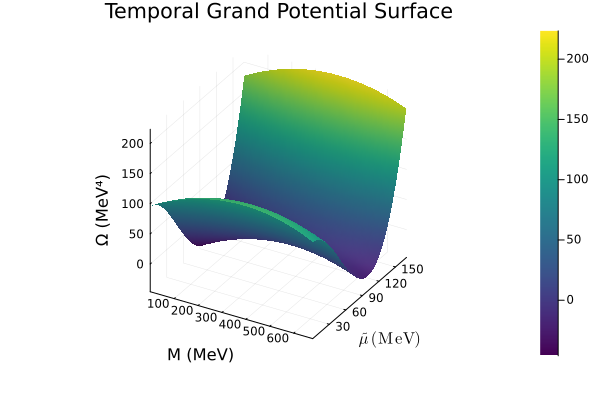

In [17]:
Temperature = 1e0
mu = 1e2
m = 5.6
Gs = 2.44/Lambda^2
Gv = Gs

M_sol, mu_tilde_sol = solve_system(Temperature, mu)  # Example values for T and μ

# Parameter grid
M_values = range(1e-3, M_sol*1.7, length=100)
mu_tilde_values = range(1e-3, mu_tilde_sol*1.7, length=100)

# Compute Omega_temp values
Omega_values = [Omega_temp(Temperature, mu, M, mu_tilde)/hbarc^3 for M in M_values, mu_tilde in mu_tilde_values]

println("Solution: M = ", M_sol, ", μ_tilde = ", mu_tilde_sol)
println("δΩ/δM = ", dOmegadM(Temperature, mu, M_sol, mu_tilde_sol))
println("δΩ/δμ_tilde = ", dOmegadmutilde(Temperature, mu, M_sol, mu_tilde_sol))

# Plot 3D surface
surface(M_values, mu_tilde_values, Omega_values; 
    xlabel="M (MeV)",
    ylabel=L"\tilde{μ}\ (\mathrm{MeV})", zlabel="Ω (MeV⁴)", title="Temporal Grand Potential Surface", color=:viridis,
    # zlims=(-50, 150),
)

In [18]:
h = sqrt(eps(Float64))

1.4901161193847656e-8

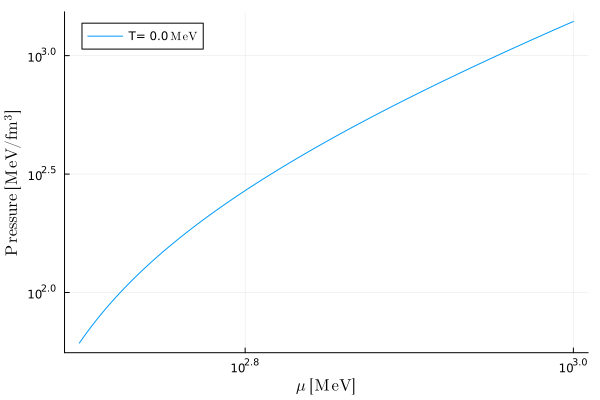

In [19]:
T_fixed = 0.0
mu_list = 5e2:1e3
plot(mu_list, abs.(pressure.(T_fixed, mu_list)./(hbarc^3));
    label=string("T= ", T_fixed, L"\ \mathrm{MeV}"),
    xlabel=L"\mu\ [\mathrm{MeV}]",
    ylabel=L"\mathrm{Pressure}\ [\mathrm{MeV/fm^3}]",
    legend=:topleft,
    xscale=:log10,
    yscale=:log10,
)

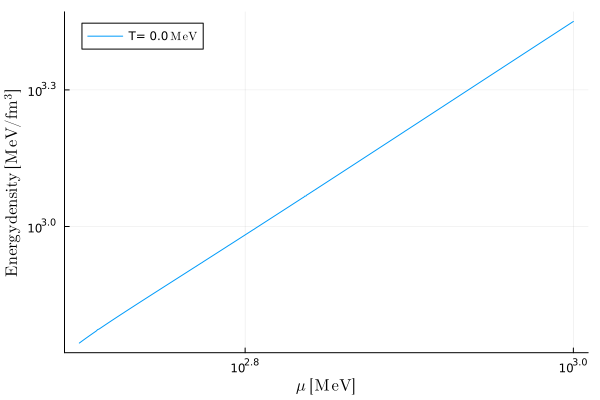

In [20]:
plot(mu_list, abs.(energy_dens.(T_fixed, mu_list)./(hbarc^3));
    label=string("T= ", T_fixed, L"\ \mathrm{MeV}"),
    xlabel=L"\mu\ [\mathrm{MeV}]",
    ylabel=L"\mathrm{Energy density}\ [\mathrm{MeV/fm^3}]",
    legend=:topleft,
    xscale=:log10,
    yscale=:log10,
)

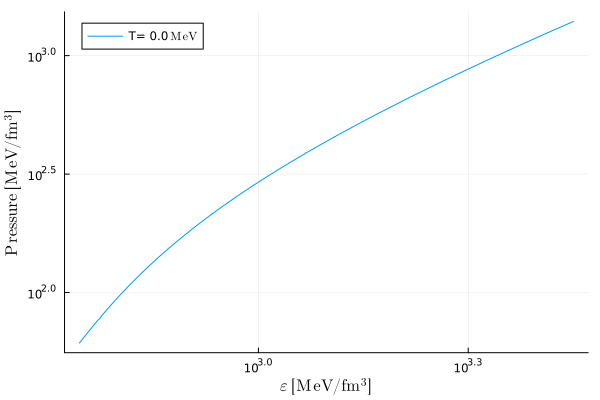

In [21]:
plot(abs.(energy_dens.(T_fixed, mu_list)./(hbarc^3)), abs.(pressure.(T_fixed, mu_list)./(hbarc^3));
    label=string("T= ", T_fixed, L"\ \mathrm{MeV}"),
    xlabel=L"\epsilon\ [\mathrm{MeV/fm^3}]",
    ylabel=L"\mathrm{Pressure}\ [\mathrm{MeV/fm^3}]",
    legend=:topleft,
    xscale=:log10,
    yscale=:log10,
)

In [22]:
function rhoB(T,μ)
    M_sol, μ_tilde_sol = solve_system(T, μ)
    return num_dens(T, μ_tilde_sol, M_sol)/(hbarc^3)/3.0/rho0
end

function EoverA(T, μ)
    M_sol, μ_tilde_sol = solve_system(T, μ)
    return 3.0*energy_dens(T,μ)/num_dens(T, μ_tilde_sol, M_sol)
end

EoverA (generic function with 1 method)

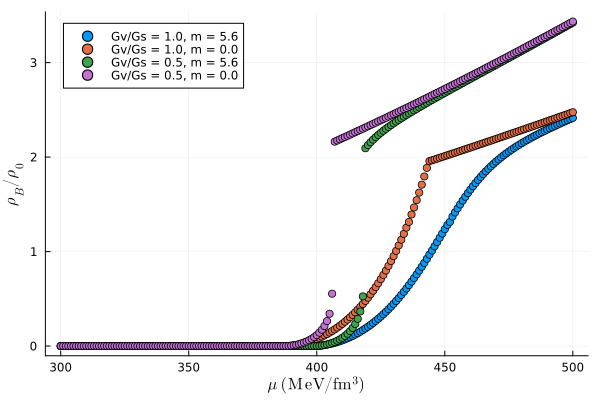

In [23]:
T_fixed = 1e-3
mu_list = 3e2:5e2
m = 5.6
Gv = Gs
scatter(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
    # xlims=(3e2, 5e2),
    # ylims=(0.0, 5.0),
    xlabel=L"\mu\ (\mathrm{MeV/fm^3})",
    ylabel=L"\rho_B/\rho_0",
)

m = 0.0
scatter!(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
)

m = 5.6
Gv = 0.5*Gs
scatter!(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
)

m = 0.0
scatter!(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
)

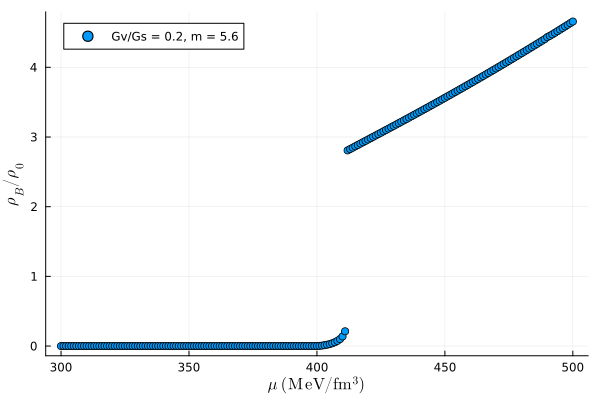

In [24]:
m = 5.6
Gv = 2e-1*Gs
scatter(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
    # xlims=(3e2, 5e2),
    # ylims=(0.0, 5.0),
    xlabel=L"\mu\ (\mathrm{MeV/fm^3})",
    ylabel=L"\rho_B/\rho_0",
)

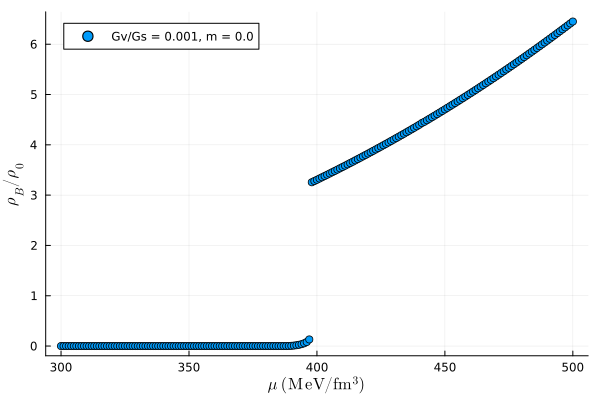

In [25]:
m = 0.0
Gv = 1e-3*Gs
scatter(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
    # xlims=(3e2, 5e2),
    # ylims=(0.0, 5.0),
    xlabel=L"\mu\ (\mathrm{MeV/fm^3})",
    ylabel=L"\rho_B/\rho_0",
)

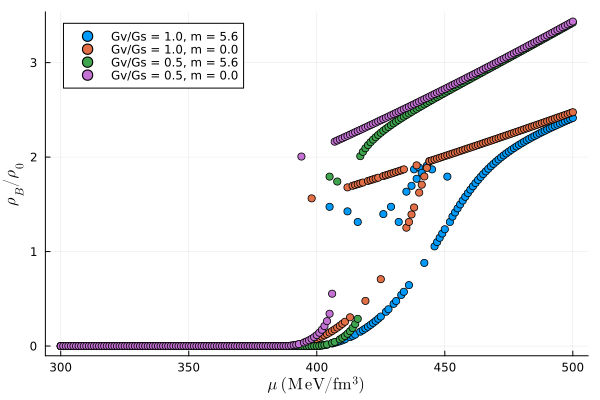

In [26]:
T_fixed = 0.0
mu_list = 3e2:5e2
m = 5.6
Gv = Gs
scatter(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
    # xlims=(3e2, 5e2),
    # ylims=(0.0, 5.0),
    xlabel=L"\mu\ (\mathrm{MeV/fm^3})",
    ylabel=L"\rho_B/\rho_0",
)

m = 0.0
scatter!(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
)

m = 5.6
Gv = 0.5*Gs
scatter!(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
)

m = 0.0
scatter!(mu_list, rhoB.(T_fixed, mu_list);
    label=string("Gv/Gs = ", Gv/Gs, ", m = ", m),
)

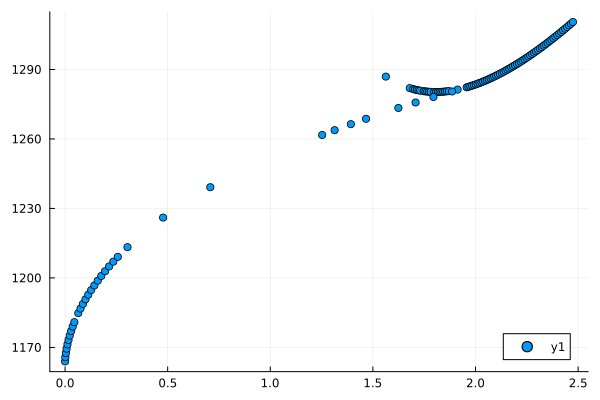

In [27]:
T_fixed = 0.0
mu_list = 1.0:5e2
m = 0.0
Gv = Gs

scatter(rhoB.(T_fixed, mu_list), EoverA.(T_fixed, mu_list);
    # xlims=(0,4),
    # ylims=(1150, 1350),
)

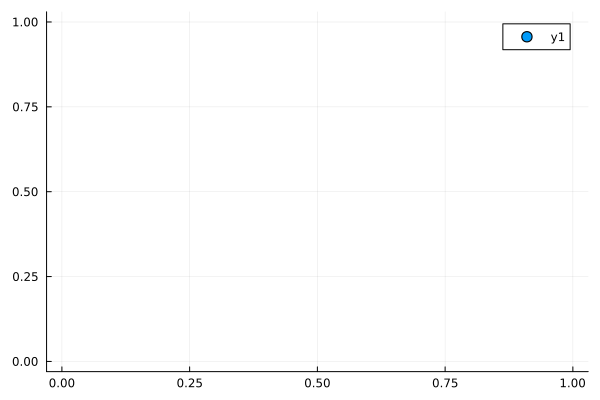

In [28]:
T_fixed = 1e-2
mu_list = 1.0:3e2
m = 0.0
Gv = Gs

scatter(rhoB.(T_fixed, mu_list), EoverA.(T_fixed, mu_list);
    # xlims=(0,4),
    # ylims=(1150, 1350),
)

In [29]:
EoverA.(T_fixed, mu_list[300])

NaN